In [65]:
import h5py
import os
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import cv2
import sklearn.metrics as metrics


from sklearn.model_selection import train_test_split,validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,classification_report
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,label_binarize

from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from skimage import feature 
from collections import Counter

# 1 Data

In [ ]:
## 1.1 Load Data

In [ ]:
# Here are the four compressed files under the data folder are downloaded from the website, 
#you can unzip it to a folder by yourself without performing this step

import zipfile
root_path = "./data"
#读取data文件夹下面的文件名字，返回四个zip文件名
files = os.listdir(root_path)
all_path =  os.path.join("./data_knn", "knn")
data = []
label = []
if not os.path.isdir(all_path):
    os.makedirs(all_path) #path_you_want_to_create
for file in files:
    data_path = os.path.join(root_path, file)
    azip = zipfile.ZipFile(data_path) 
    azip.extractall(all_path)
    

mat_path = [os.path.join(all_path,name) for name in os.listdir(all_path)]

f = h5py.File(mat_path[1])
k1 = f.keys() #shows the keys in the first level
#现在，要查看存储的所有数据，我可以执行以下操作：
for k1 in f:
    for k2 in f[k1].keys():
        print(f[k1][k2]) 
print(f["cjdata"]["label"][0][0])
f.close()

In [2]:
%%time
all_path =  os.path.join("./data_knn", "knn")
mat_path = [os.path.join(all_path,name) for name in os.listdir(all_path)]


def extract_data(mat_path):
    image = []
    label = []
    tumorMask = []
    image_mask = []
    
    for file in mat_path:
        with h5py.File(file, 'r') as f:
            image_ind = f["cjdata"]["image"][()]
            mask = f["cjdata"]["tumorMask"][()]
            #Pad image to same size
            if image_ind.shape != (512, 512):
                image_ind = np.pad(image_ind, ((128, 128), (128, 128)), mode='constant')
                mask = np.pad(mask, ((128, 128), (128, 128)), mode='constant')
                # print(image.shape)
                assert image_ind.shape == (512, 512)
                assert mask.shape == (512, 512)
            data_sample = image_ind * mask
            image_mask.append(data_sample)    
            label.append(int(f["cjdata"]["label"][0][0]))
            tumorMask.append(mask)
            image.append(image_ind)
    return image,label,tumorMask,image_mask
image,label,tumorMask,image_mask = extract_data(mat_path)
label = np.array(label)
del all_path,mat_path

Wall time: 13.4 s


## 1.2 Data Normalization 

Here I scaled the data into the range of [-1, 1] to speed up the SVM learning process.

In [3]:
def data_normalization(image_mask):
    image_mask = np.array(image_mask)
    image_mask_v = image_mask.reshape(image_mask.shape[0], -1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    image_mask_v = scaler.fit_transform(image_mask_v)
    return image_mask_v

## 1.3 Data Visualization

In [4]:
%%time
def data_visual(image,label):
    
    # Count the number of occurrences of each element
    label_count = Counter(label)
    print('label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor'+ str(label_count))
    pd.DataFrame(label).hist()

    #dtype=int16
    plt.figure()
    for i in range(1,32):
        plt.subplot(4,8,i)
        plt.imshow(image[i-1])   
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
    plt.figure()
    for i in range(1,9):
        plt.subplot(4,8,i)
        plt.imshow(tumorMask[i-1])   
        plt.xticks([])
        plt.yticks([])
    plt.show()
def label_visual(image_mask,label):
    data = data_normalization(image_mask)
    X_tsne = TSNE(n_components=2, random_state=33).fit_transform(data)
    plt.figure(figsize=(4, 4))
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=label, alpha=0.6, 
                cmap=plt.cm.get_cmap('rainbow', 3))
    plt.title("Data")
    cbar = plt.colorbar(ticks=range(3)) 
    cbar.set_label(label='class')

Wall time: 0 ns


label: 1 for meningioma, 2 for glioma, 3 for pituitary tumorCounter({2: 1426, 3: 930, 1: 708})


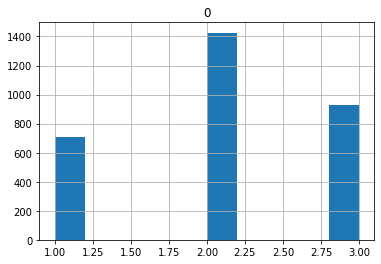

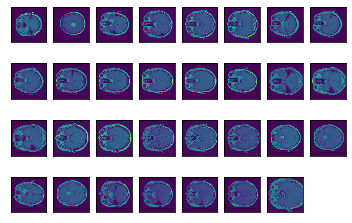

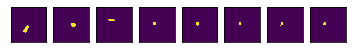

Wall time: 1.25 s


In [5]:
%%time
data_visual(image,label)

Wall time: 56min 15s


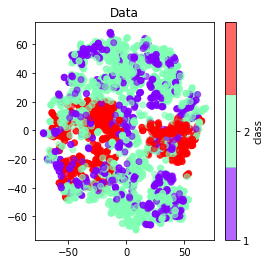

In [16]:
%%time
label_visual(image_mask,label)

In [6]:
## 1.4  Data Processing

In [49]:
def dtype_int8(tumorMask):
    if tumorMask[0].dtype == 'int16':
        for i in range(len(tumorMask)):
            tumorMask[i] = tumorMask[i].astype(np.uint8)
    
    return tumorMask

In [7]:
### 1.4.1  Edge Detection

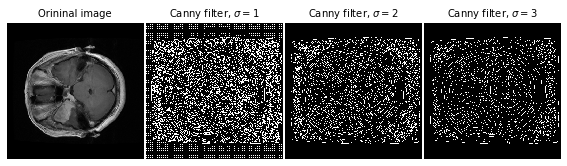

In [8]:

def canny_visual(image):
    # Compute the Canny filter for two values of sigma

    im = image[0]
    edges1 = feature.canny(im,1,0.3,0.2)
    edges2 = feature.canny(im, 2, 0.3, 0.2)
    edges3 = feature.canny(im, 3, 0.3, 0.2)
    # display results
    fig, (ax1, ax2, ax3,ax4) = plt.subplots(nrows=1, ncols=4, figsize=(8, 3), sharex=True, sharey=True)
    
    ax1.imshow(im,cmap=plt.cm.gray)
    ax1.axis('off')
    ax1.set_title('Orininal image', fontsize=10)
    
    ax2.imshow(edges1,cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.set_title('Canny filter, $\sigma=1$', fontsize=10)
    
    ax3.imshow(edges2, cmap=plt.cm.gray)
    ax3.axis('off')
    ax3.set_title('Canny filter, $\sigma=2$', fontsize=10)
    
    ax4.imshow(edges3, cmap=plt.cm.gray)
    ax4.axis('off')
    ax4.set_title('Canny filter, $\sigma=3$', fontsize=10)
    
    fig.subplots_adjust(wspace=0.02, hspace=0.02, top=0.9,
                        bottom=0.02, left=0.02, right=0.98)
    
    plt.show()
def canny_detection(image,sigma_canny):
    edges = feature.canny(image,sigma_canny,0.3,0.2)
    canny_arr = np.array(edges.astype(int))
    # Flatten output array
    #canny_flat = canny_arr.flatten()

    return canny_arr
canny_visual(image)

In [9]:
### 1.4.2  Smoothing Images

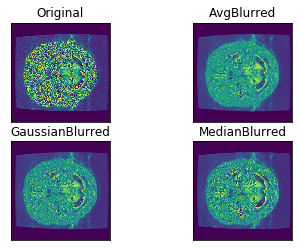

Wall time: 142 ms


In [10]:
%%time
#reference:https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
def blur_visual(image):
    im = image[0]
    im = im.astype(np.uint8)
    
    blur = cv2.blur(im,(5,5))
    blur1 = cv2.GaussianBlur(im,(5,5),0)
    median = cv2.medianBlur(im,5)
    
    plt.subplot(2, 2, 1), plt.imshow(im),plt.title('Original')
    plt.xticks([]),plt.yticks([])
    plt.subplot(2, 2, 2),plt.imshow(blur),plt.title('AvgBlurred')
    plt.xticks([]),plt.yticks([])
    plt.subplot(2, 2, 3),plt.imshow(blur1),plt.title('GaussianBlurred')
    plt.xticks([]),plt.yticks([])
    plt.subplot(2, 2, 4),plt.imshow(median),plt.title('MedianBlurred')
    plt.xticks([]),plt.yticks([])
    plt.show()
blur_visual(image)

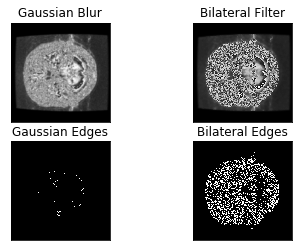

In [11]:
def blurImage(targetImage):
    targetImage = targetImage[0].astype(np.uint8)
    gaussianBlur = cv2.GaussianBlur(targetImage, (15, 15), 0)
    bilateralBlur = cv2.bilateralFilter(targetImage, 15, 45, 155)
    gaussianCanny = cv2.Canny(gaussianBlur, 100, 200)
    bilateralCanny = cv2.Canny(bilateralBlur, 100, 200)
    plt.subplot(2,2,1),plt.imshow(gaussianBlur, cmap = 'gray')
    plt.title('Gaussian Blur'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2),plt.imshow(bilateralBlur, cmap = 'gray')
    plt.title('Bilateral Filter'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,3),plt.imshow(gaussianCanny, cmap = 'gray')
    plt.title('Gaussian Edges'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,4),plt.imshow(bilateralCanny, cmap = 'gray')
    plt.title('Bilateral Edges'), plt.xticks([]), plt.yticks([])
    plt.show()

    return gaussianBlur, bilateralBlur
gaussianBlur, bilateralBlur = blurImage(image)
del gaussianBlur ,bilateralBlur

In [50]:
def blur_imgae(tumorMask):
    mask_gaussianBlur = []
    mask_bilateralBlur = []
    tumorMask = dtype_int8(tumorMask)
    for tumor in tumorMask:
        gaussianBlur = cv2.GaussianBlur(tumor, (15, 15), 0)
        bilateralBlur = cv2.bilateralFilter(tumor, 15, 45, 155)
        mask_gaussianBlur.append(gaussianBlur)
        mask_bilateralBlur.append(bilateralBlur)
    return mask_gaussianBlur,mask_bilateralBlur

In [ ]:
### 1.4.3  Threshold Images

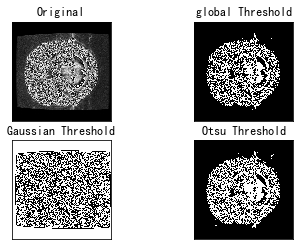

In [52]:
def binarizeImage(image):
    image = image[0].astype(np.uint8)
    _, globalBinImage = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    gaussBinImage = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    _, otsuBinImage = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    plt.subplot(2,2,1)
    plt.imshow(image, cmap = 'gray')
    plt.title('Original'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,2)
    plt.imshow(globalBinImage, cmap = 'gray')
    plt.title('global Threshold'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,3)
    plt.imshow(gaussBinImage, cmap = 'gray')
    plt.title('Gaussian Threshold'), plt.xticks([]), plt.yticks([])
    plt.subplot(2,2,4)
    plt.imshow(otsuBinImage, cmap = 'gray')
    plt.title('Otsu Threshold'), plt.xticks([]), plt.yticks([])
    plt.show()
binarizeImage(image)   

# 2. Do Train-Test Split

In [12]:
def train_split(image_mask,label):
    image_mask = data_normalization(image_mask)
    X_train, X_test, y_train, y_test = train_test_split(image_mask, label, test_size=0.33, random_state=42)
    return X_train, X_test, y_train, y_test

# 3. KNN

## 3.1. KNN Model

In [22]:
def predict_KNN(image_mask,label,k):
    X_train, X_test, y_train, y_test = train_split(image_mask,label)
    # 初始化、训练k-NN分类器
    print("[INFO] evaluating k-NN classifier...")
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds_knn = knn.predict(X_test)
    return y_test,preds_knn       

Wall time: 0 ns


## 3.2. KNN Prediction

In [23]:
%%time
#13min 59s
y_test,preds_TM_4 = predict_KNN( tumorMask,label,4)
y_test,preds_IM_4 = predict_KNN( image_mask,label,4)
y_test,preds_I_4 = predict_KNN( image,label,4)

[INFO] evaluating k-NN classifier...
[INFO] evaluating k-NN classifier...
[INFO] evaluating k-NN classifier...
Wall time: 40min 37s


## 3.3. KNN Evaluation

In the evaluation process, I computed the Accuracy, Precision, Recall and F1-Score for each model.

In [13]:
def report_AUC(y_test,preds_knn,label):
    print('Accuracy:', accuracy_score(y_test,preds_knn))
    print('Precision:', precision_score(y_test,preds_knn,average='macro'))
    print('Recall:', recall_score(y_test,preds_knn,average='macro'))
    print('F1-Score:', f1_score(y_test,preds_knn,average='macro'))
    print('The classification report on Brain Tumor by using KNN ：','\n',
      classification_report(y_test,
            preds_knn))
    
    label_type = set(label)
    n_class = len(label_type)
    y_one_hot = label_binarize(y_test, np.arange(n_class))  #Replace it with a binary code
    
    preds_knn_hot = label_binarize(preds_knn, np.arange(n_class))  #Replace it with a binary code
    #First expand the matrices y_one_hot and y_score, and then calculate the false positive rate FPR and the true rate TPR
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),preds_knn_hot.ravel())
    auc = metrics.auc(fpr, tpr)
    print ('auc：', auc)
    #plot
    mpl.rcParams['font.sans-serif'] = u'SimHei'
    mpl.rcParams['axes.unicode_minus'] = False
    #FPR is the abscissa, TPR is the ordinate
    plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
    plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid(b=True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
    plt.title(u'ROC and AUC ', fontsize=17)
    plt.show()

In [40]:
def three_vs(label,y_test,preds_LK,preds_PK,preds_RBF,name1,name2,name3,titlename):
    label_type = set(label)
    n_class = len(label_type)
    y_one_hot = label_binarize(y_test, np.arange(n_class))  #Replace it with a binary code

    plt.figure(0).clf()  # plt.close()The graph window will be closed completely
    mpl.rcParams['font.sans-serif'] = u'SimHei'
    mpl.rcParams['axes.unicode_minus'] = False
    
    preds_LK_hot = label_binarize(preds_LK, np.arange(n_class))  
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),preds_LK_hot.ravel())
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC(%s)=%.3f' % (name1,auc))
    
    preds_PK_hot = label_binarize(preds_PK, np.arange(n_class))  #Replace it with a binary code
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),preds_PK_hot.ravel())
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c = 'b', lw = 2, alpha = 0.7, label = u'AUC(%s)=%.3f' % (name2,auc))
    
    preds_RBF_hot = label_binarize(preds_RBF, np.arange(n_class))  #Replace it with a binary code
    fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),preds_RBF_hot.ravel())
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, c = 'g', lw = 2, alpha = 0.7, label = u'AUC(%s)=%.3f' % (name3,auc))
    
    plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid(b=True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
    plt.title(u'ROC and AUC %s '%titlename, fontsize=17)
    plt.legend(loc=0) 
    plt.show()

Since the tumor type is  decided by the tumor area, so I will also use element-wise product with `tumormask` and `image` to get the tumor area as input. 

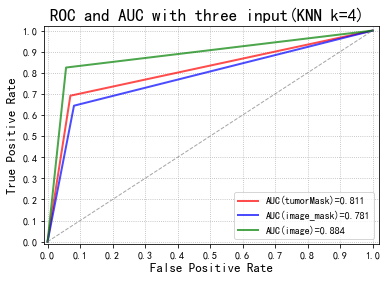

In [41]:
three_vs(label,y_test,preds_TM_4,preds_IM_4,preds_I_4,'tumorMask','image_mask','image','with three input(KNN k=4)')

Therefore, the besk input is **image**

## 3.3. Hyperparameter Tuning

In [45]:
def hyper_k_tuning(image_mask,label):
    param_name = 'n_neighbors'
    param_range = range(2,15,4 )
    X_train, _, y_train, _ = train_split(image_mask,label)
    #scoring: accuracy for classification, mean_squared_error for regression
    train_scores, test_scores = validation_curve(
        KNeighborsClassifier(), X_train, y_train, cv=5,
        param_name=param_name, param_range=param_range,
        scoring='accuracy')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(0).clf()
    mpl.rcParams['font.sans-serif'] = u'SimHei'
    mpl.rcParams['axes.unicode_minus'] = False
    plt.plot(param_range,train_scores_mean, color='red', label=u'train')
    plt.plot(param_range, test_scores_mean, color='green', label=u'test')
    plt.legend('best')
    plt.xlabel('param range of k')
    plt.ylabel('scores mean')
    plt.title(u'Hyperparameter K Choose', fontsize=17)
    plt.show()

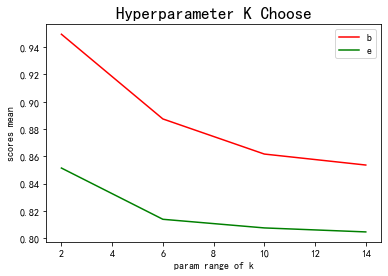

Wall time: 6h 52min 14s


In [48]:
%%time
hyper_k_tuning(image,label)

Therefore, the besk k value is **k=2**

## 3.4 Feature Engineering

### 3.4.1 BLUR

In [54]:
def blur_imgae(tumorMask):
    mask_gaussianBlur = []
    mask_bilateralBlur = []
    tumorMask = dtype_int8(tumorMask)
    for tumor in tumorMask:
        gaussianBlur = cv2.GaussianBlur(tumor, (15, 15), 0)
        bilateralBlur = cv2.bilateralFilter(tumor, 15, 45, 155)
        mask_gaussianBlur.append(gaussianBlur)
        mask_bilateralBlur.append(bilateralBlur)
    return mask_gaussianBlur,mask_bilateralBlur

[INFO] evaluating k-NN classifier...
[INFO] evaluating k-NN classifier...
[INFO] evaluating k-NN classifier...
Accuracy: 0.8023715415019763
Precision: 0.8011850187293241
Recall: 0.793094459658696
F1-Score: 0.7965031435637044
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.79      0.72      0.75       251
           2       0.80      0.83      0.82       446
           3       0.81      0.83      0.82       315

    accuracy                           0.80      1012
   macro avg       0.80      0.79      0.80      1012
weighted avg       0.80      0.80      0.80      1012

auc： 0.8655518704421257


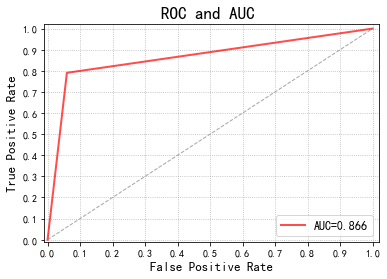

Accuracy: 0.9209486166007905
Precision: 0.915981271077211
Recall: 0.9205152862344722
F1-Score: 0.9162927981109799
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.80      0.92      0.86       251
           2       0.95      0.92      0.94       446
           3       1.00      0.92      0.96       315

    accuracy                           0.92      1012
   macro avg       0.92      0.92      0.92      1012
weighted avg       0.93      0.92      0.92      1012

auc： 0.9443749950162026


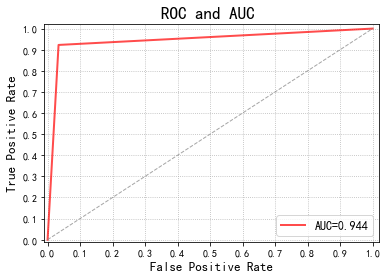

Accuracy: 0.857707509881423
Precision: 0.8685655355983966
Recall: 0.8456692602262788
F1-Score: 0.853864078734545
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.80      0.80      0.80       251
           2       0.82      0.91      0.86       446
           3       0.98      0.83      0.90       315

    accuracy                           0.86      1012
   macro avg       0.87      0.85      0.85      1012
weighted avg       0.87      0.86      0.86      1012

auc： 0.9062276304175411


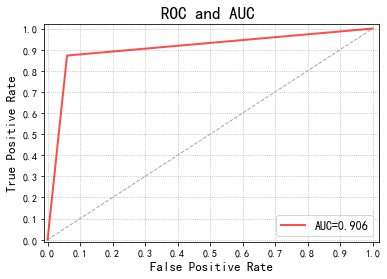

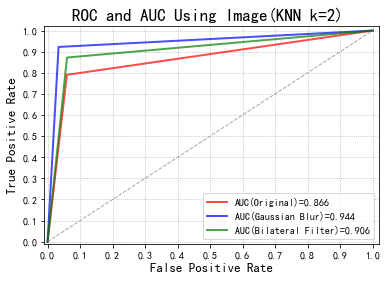

Wall time: 53min 1s


In [55]:
%%time
image_gaussianBlur,image_bilateralBlur = blur_imgae(image)
y_test,preds_k_Gblur = predict_KNN( image_gaussianBlur,label,2)
y_test,preds_k_Bblur = predict_KNN( image_bilateralBlur,label,2)
y_test,preds_k_2 = predict_KNN( image,label,2)
report_AUC(y_test,preds_k_2,label)
report_AUC(y_test,preds_k_Gblur,label)
report_AUC(y_test,preds_k_Bblur,label)
three_vs(label,y_test,preds_k_2,preds_k_Gblur,preds_k_Bblur,'Original','Gaussian Blur','Bilateral Filter','Using Image(KNN k=2)')
del image_gaussianBlur,image_bilateralBlur

### 3.4.2 THRESHOLD

In [56]:
def binarizeImage(image):
    globalBinImage = [] 
    gaussBinImage = []
    otsuBinImage = []
    image = dtype_int8(image)
    for im in image :
        _, globalBin = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY)
        gaussBin = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        _, otsuBin = cv2.threshold(im, 127, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
     
        globalBinImage.append(globalBin)
        gaussBinImage.append(gaussBin)
        otsuBinImage.append(otsuBin)
    return globalBinImage, gaussBinImage, otsuBinImage

[INFO] evaluating k-NN classifier...
[INFO] evaluating k-NN classifier...
[INFO] evaluating k-NN classifier...
Accuracy: 0.5938735177865613
Precision: 0.6181114926535353
Recall: 0.6298598521187984
F1-Score: 0.5887181456175408
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.48      0.69      0.56       251
           2       0.78      0.38      0.51       446
           3       0.60      0.83      0.69       315

    accuracy                           0.59      1012
   macro avg       0.62      0.63      0.59      1012
weighted avg       0.65      0.59      0.58      1012

auc： 0.6939571227817501


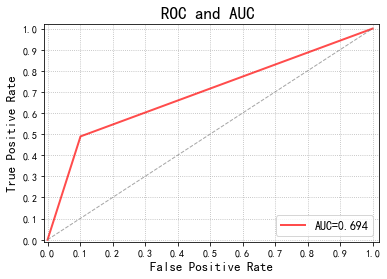

Accuracy: 0.6521739130434783
Precision: 0.7314330543316051
Recall: 0.6257321155504209
F1-Score: 0.6059390272385898
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.74      0.27      0.39       251
           2       0.97      0.65      0.78       446
           3       0.48      0.96      0.64       315

    accuracy                           0.65      1012
   macro avg       0.73      0.63      0.61      1012
weighted avg       0.76      0.65      0.64      1012

auc： 0.750691751064079


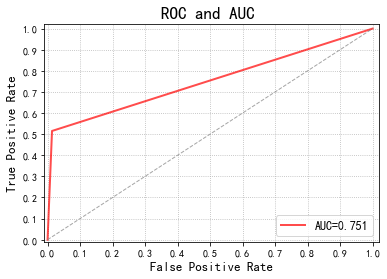

Accuracy: 0.6976284584980237
Precision: 0.6928203017872989
Recall: 0.695919669129967
F1-Score: 0.6927627681897133
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.56      0.65      0.60       251
           2       0.73      0.69      0.71       446
           3       0.79      0.75      0.77       315

    accuracy                           0.70      1012
   macro avg       0.69      0.70      0.69      1012
weighted avg       0.71      0.70      0.70      1012

auc： 0.7857175717344781


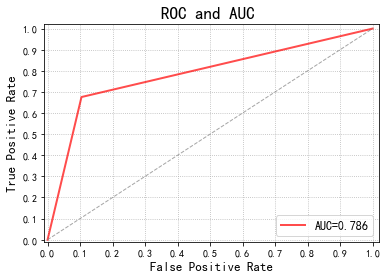

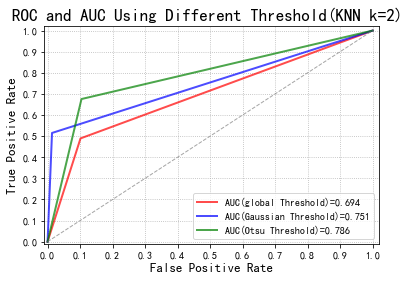

Wall time: 42min 4s


In [58]:
%%time
globalBinImage, gaussBinImage, otsuBinImage = binarizeImage(image)
y_test,preds_GB_thre = predict_KNN( globalBinImage,label,2)
y_test,preds_Gaussin_thre = predict_KNN( gaussBinImage,label,2)
y_test,preds_otsu_thre = predict_KNN( otsuBinImage,label,2)
report_AUC(y_test,preds_GB_thre,label)
report_AUC(y_test,preds_Gaussin_thre,label)
report_AUC(y_test,preds_otsu_thre,label)
three_vs(label,y_test,preds_GB_thre,preds_Gaussin_thre,preds_otsu_thre,'global Threshold','Gaussian Threshold','Otsu Threshold','Using Different Threshold(KNN k=2)')

### 3.4.3 Canny

In [63]:
def canny_detection(image,sigma_canny):
    edges = feature.canny(image,sigma_canny,0.3,0.2)
    canny_arr = np.array(edges.astype(np.uint8))
    # Flatten output array
    #canny_flat = canny_arr.flatten()
    return canny_arr

def canny_image(image,label,sigma_canny):
    canny_edge = []
    for im in image:
        canny = canny_detection(im,sigma_canny)
        canny_edge.append(canny)
    return canny_edge


[INFO] evaluating k-NN classifier...
Accuracy: 0.31126482213438733
Precision: 0.10375494071146245
Recall: 0.3333333333333333
F1-Score: 0.15825169555388094
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00       251
           2       0.00      0.00      0.00       446
           3       0.31      1.00      0.47       315

    accuracy                           0.31      1012
   macro avg       0.10      0.33      0.16      1012
weighted avg       0.10      0.31      0.15      1012

auc： 0.5


F:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
F:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


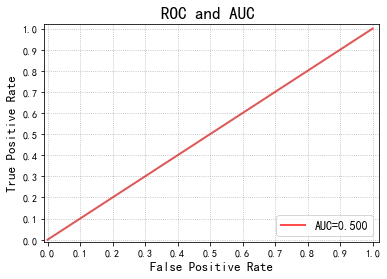

Wall time: 18min 55s


In [64]:
%%time
canny_edge = canny_image(image,label,2)
y_test,preds_k_cany2 = predict_KNN( canny_edge,label,2)
report_AUC(y_test,preds_k_cany2,label)

# 4. Train SVM

Here I initialized three different SVM models with different kernels, they are SVM with Radial Basis Function Kernel, SVM with Linear Kernel and SVM with Polynomial Kernel.

## 3.1. SVM Model

In [24]:
def SVM_kernel(image_mask,label):
    clf_linear = SVC(kernel="linear", decision_function_shape="ovr", gamma='auto', verbose=True)
    clf_poly = SVC(kernel="poly", decision_function_shape="ovr", gamma='auto', verbose=True)
    clf_rbf = SVC(kernel="rbf", decision_function_shape="ovr", gamma='auto', verbose=True)
    
    X_train, X_test, y_train, y_test = train_split(image_mask,label)
    
    clf_linear.fit(X_train, y_train)
    clf_poly.fit(X_train, y_train)
    clf_rbf.fit(X_train, y_train)
    
    preds_LK = clf_linear.predict(X_test)
    preds_PK = clf_poly.predict(X_test)
    preds_RBF = clf_rbf.predict(X_test)
    return y_test,preds_LK,preds_PK,preds_RBF

## 3.2. SVM Prediction

In [25]:
y_test,preds_LK,preds_PK,preds_RBF = SVM_kernel(tumorMask,label)

[LibSVM][LibSVM][LibSVM]

## 3.3. SVM Evaluation

### 3.3.1 Linear Kernel Result

Accuracy: 0.7164031620553359
Precision: 0.6964456587014048
Recall: 0.6982717196320184
F1-Score: 0.6965038155457902
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.56      0.51      0.53       251
           2       0.74      0.74      0.74       446
           3       0.78      0.84      0.81       315

    accuracy                           0.72      1012
   macro avg       0.70      0.70      0.70      1012
weighted avg       0.71      0.72      0.71      1012

auc： 0.7835222473644148


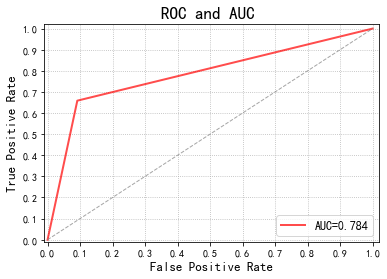

In [37]:
report_AUC(y_test,preds_LK,label)

### 3.3.2 Polynomial Kernel Result

Accuracy: 0.6699604743083004
Precision: 0.6423443195183782
Recall: 0.6034143540673474
F1-Score: 0.5281657224820521
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.58      0.03      0.05       251
           2       0.66      0.84      0.74       446
           3       0.68      0.95      0.79       315

    accuracy                           0.67      1012
   macro avg       0.64      0.60      0.53      1012
weighted avg       0.65      0.67      0.59      1012

auc： 0.7313398962020704


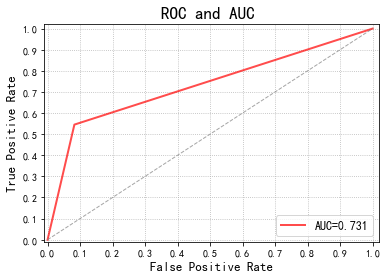

In [38]:
report_AUC(y_test,preds_PK,label)

### 3.3.3 Radial Basis Function Kernel Result

Accuracy: 0.6669960474308301
Precision: 0.6450843903750004
Recall: 0.599782103937679
F1-Score: 0.516813146628147
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.60      0.01      0.02       251
           2       0.66      0.83      0.74       446
           3       0.67      0.96      0.79       315

    accuracy                           0.67      1012
   macro avg       0.65      0.60      0.52      1012
weighted avg       0.65      0.67      0.58      1012

auc： 0.7278908017810405


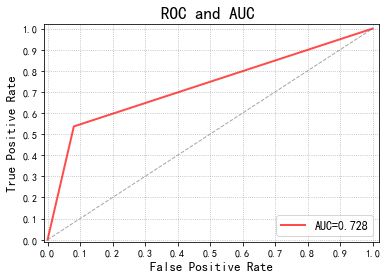

In [39]:
report_AUC(y_test,preds_RBF,label)

### 3.3.3 The Comparison Among three kernels

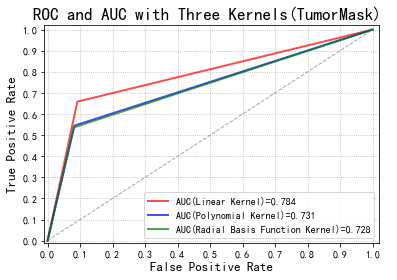

In [42]:
three_vs(label,y_test,preds_LK,preds_PK,preds_RBF,'Linear Kernel','Polynomial Kernel','Radial Basis Function Kernel','with Three Kernels(TumorMask)')

As we can see above, the SVM with **Linear Kernel** got the best result while the model with Radial Basis Function Kernel got the worst. We can also tell that the Radial Basis Function model is even worse than random guess from Precision(lower than 33%). This may be caused by the dimension of each data sample is too high and there is not enough data to fit a high dimensional function. So an SVM with a linear kernel may be the best choice in this case.

In [70]:
def SVM_Linear_hard(image,label):
    #C larger:the lower the degree of regularization, the more inclined the border, the smaller the margin
    clf_linear = LinearSVC(random_state=42)
    X_train, X_test, y_train, y_test = train_split(image,label)
    clf_linear.fit(X_train, y_train)
    preds_LK = clf_linear.predict(X_test)
    return y_test,preds_LK

F:\anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.9021739130434783
Precision: 0.8948364194501143
Recall: 0.8967721304026308
F1-Score: 0.8957619460872431
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.82      0.82      0.82       251
           2       0.91      0.90      0.91       446
           3       0.95      0.97      0.96       315

    accuracy                           0.90      1012
   macro avg       0.89      0.90      0.90      1012
weighted avg       0.90      0.90      0.90      1012

auc： 0.9184123247313503


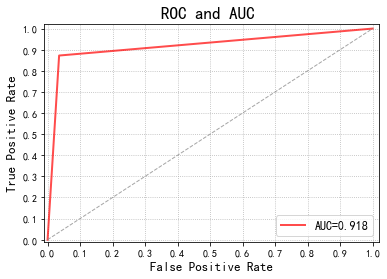

Wall time: 36min 8s


In [71]:
%%time
y_test,preds_Linear_hard = SVM_Linear_hard(image,label)
report_AUC(y_test,preds_Linear_hard,label)

## 3.4 SVM Soft Margin

In [59]:

def SVM_Linear(image,label):
    #C larger:the lower the degree of regularization, the more inclined the border, the smaller the margin
    clf_linear = LinearSVC(C=1,loss="hinge",random_state=42)
    X_train, X_test, y_train, y_test = train_split(image,label)
    clf_linear.fit(X_train, y_train)
    preds_LK = clf_linear.predict(X_test)
    return y_test,preds_LK
def blur_gaussian_bilateral(tumorMask):
    blur_two = []
    tumorMask = dtype_int8(tumorMask)
    for tumor in tumorMask:
        gaussianBlur = cv2.GaussianBlur(tumor, (15, 15), 0)
        bilateralBlur = cv2.bilateralFilter(gaussianBlur, 15, 45, 155)
        blur_two.append(bilateralBlur)
    return blur_two

F:\anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
F:\anaconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.9021739130434783
Precision: 0.8948364194501143
Recall: 0.8967721304026308
F1-Score: 0.8957619460872431
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.82      0.82      0.82       251
           2       0.91      0.90      0.91       446
           3       0.95      0.97      0.96       315

    accuracy                           0.90      1012
   macro avg       0.89      0.90      0.90      1012
weighted avg       0.90      0.90      0.90      1012

auc： 0.9184123247313503


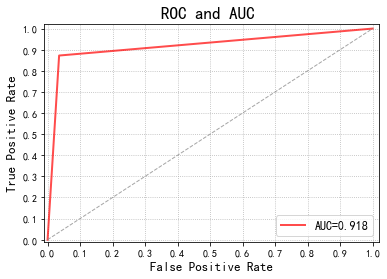

Accuracy: 0.8794466403162056
Precision: 0.8714987552306797
Recall: 0.8648203872294058
F1-Score: 0.8678416923226738
The classification report on Brain Tumor by using KNN ： 
               precision    recall  f1-score   support

           1       0.79      0.75      0.76       251
           2       0.88      0.92      0.90       446
           3       0.95      0.93      0.94       315

    accuracy                           0.88      1012
   macro avg       0.87      0.86      0.87      1012
weighted avg       0.88      0.88      0.88      1012

auc： 0.9058184989967999


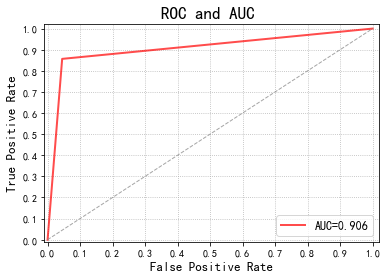

Wall time: 57min 23s


In [60]:
%%time
blur_two = blur_gaussian_bilateral(image)
y_test,preds_Linear = SVM_Linear(image,label)
y_test,preds_L_blur_two = SVM_Linear(blur_two,label)
report_AUC(y_test,preds_Linear,label)
report_AUC(y_test,preds_L_blur_two,label)